# Result analysis

In [96]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import baseline
import numpy as np
from baseline import *
from decoder import *
from alphabet import *
from train import *
import torch
from matplotlib import pyplot as plt
import collections

torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.4.0'

### Dataset and language setup

In [159]:
LANGUAGE = "Python"

def filter_ascii(strings):
    'Returns only the strings that can be encoded in ASCII.'
    l = []
    for s in strings:
        try:
            s.encode('ascii')
            if 10 <= len(s) <= 80:
                l.append(s)
        except UnicodeEncodeError:
            pass

    return list(set(l))

def language_2_dataset(language='Python'):
    with open('dataset/large.json') as f:
        multilang_dataset = json.load(f)
        dataset = multilang_dataset[language]

        dataset['train'] = filter_ascii(dataset['train'])
        dataset['dev'] = filter_ascii(dataset['dev'])
        dataset['test'] = filter_ascii(dataset['test'])
        print('{} training examples, {} validation examples, {} test exampless'.format(
            len(dataset['train']), 
            len(dataset['dev']),
            len(dataset['test'])))
        return dataset
    
full_dataset = {
    "python": language_2_dataset("Python"),
    "haskell": language_2_dataset("Haskell"),
    "java": language_2_dataset("Java"),
}

602762 training examples, 80964 validation examples, 80789 test exampless
616686 training examples, 82731 validation examples, 82543 test exampless
565796 training examples, 77886 validation examples, 77884 test exampless


## Models we ran

In [169]:
python_dat = full_dataset["python"]
java_dat = full_dataset["java"]
haskell_dat = full_dataset["haskell"]

models = [
    (UniformEncoder(removal_probability=.7),.0005, python_dat, 'python'),
    (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python'), 
    (RulesBasedEncoder(), .0001, python_dat, 'python'),
    (UniformEncoder(removal_probability=.9) , .0001, python_dat, 'python'), 
    (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'), 
    #(FrequencyEncoder(dataset=python_dat['train'], compression_rate=.9, n_gram=5), .0005, python_dat, 'python'), 
    (UniformFrequencyHybridEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5, removal_probability=0.8), .0005, python_dat, 'python'),
    #(NonDeterministicFrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'),
    #(FrequencyEncoderConstantDrop(dataset=python_dat['train'], num_chars=5, n_gram=5), .0005, python_dat, 'python'),
    #(FrequencyEncoderConstantDrop(java_dat['train'], num_chars=5, n_gram=5), .0005, java_dat, 'java'),
    #(FrequencyEncoderConstantDrop(haskell_dat['train'], num_chars=5, n_gram=5), .0005, haskell_dat, 'haskell'),
    #(UniformEncoderConstantDrop(num_chars=5), .0005, python_dat, 'python'),
    #(UniformEncoderConstantDrop(num_chars=5), .0005, java_dat, 'java'),
    #(UniformEncoderConstantDrop(num_chars=5), .0005, haskell_dat, 'haskell'),
]

In [170]:
def load_model(model, is_baseline=True, load_best=False):
    device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
    encoder, alpha, dataset, lang_name = model

    if load_best:
        # Load the best model saved during training.
        filename = "trained_models/{}_best_".format(encoder.name())
        loss_history_filename = "trained_models/best_model_{}".format(encoder.name())
    else:
        # Load the final model.
        filename = "trained_models/{}_{}_{}".format(encoder.name(), alpha, lang_name)
        loss_history_filename = "trained_models/{}_{}_{}.json".format(encoder.name(), alpha, lang_name)

    alphabet = AsciiEmbeddedEncoding(device)
    decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512, copy=None)    
    decoder.load_state_dict(torch.load(filename + "decoder.model"))
    alphabet.load_state_dict(torch.load(filename + "alphabet.model"))
    
    decoder.to(device)
    alphabet.to(device)
    
    if not is_baseline:
        encoder.load_state_dict(torch.load(filename + "encoder.model"))

    with open(loss_history_filename) as f:
        j = json.load(f)
        loss_history = j["losses"]
        
    return (encoder, decoder, alphabet, lang_name, loss_history)

loaded_models = []

for m in models:
    try:
        loaded_models.append(load_model(m))
        print('Model', m[0].name(), m[3], 'loaded!')
    except Exception as e:
        pass
        
print(len(loaded_models), 'model(s) loaded.')

Model UniformEncoder(0.70) python loaded!
Model UniformEncoder(0.80) python loaded!
Model RulesBasedEncoderPython(whitespace=False) python loaded!
Model UniformEncoder(0.90) python loaded!
Model FrequencyEncoder(5-gram, target_size:0.8) python loaded!
Model UniformFrequencyHybridEncoder(5-gram, target_size:0.8) python loaded!
6 model(s) loaded.


# Plot loss history

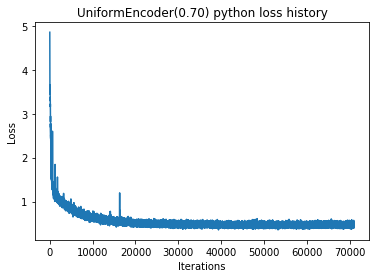

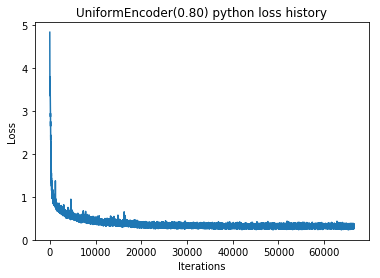

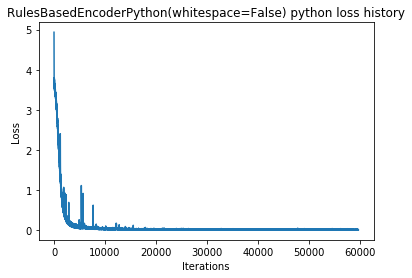

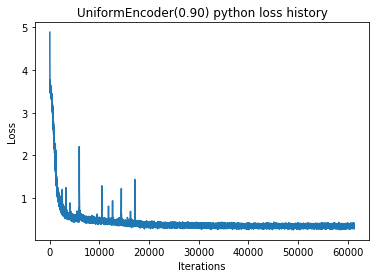

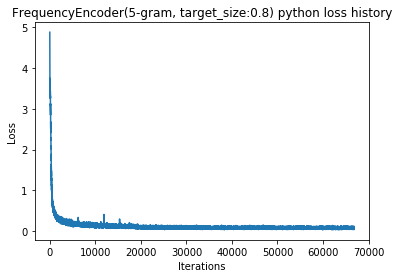

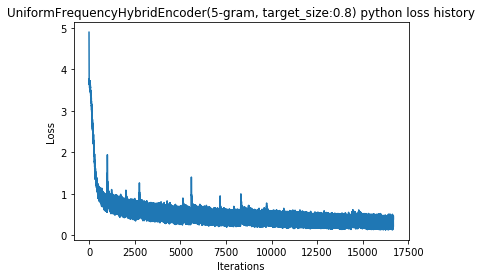

In [171]:
for (encoder, decoder, alphabet, lang, loss_history) in loaded_models:
    plt.title('{} {} loss history'.format(encoder.name(), lang))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(loss_history)
    plt.show()


# Metrics

In [140]:
BATCH_SIZE = 128

def reset_seeds():
    # Set seed before computing accuracy to make the encoders deterministic.
    np.random.seed(224)
    random.seed(224)
    torch.manual_seed(224)

# TOOD: move these to a file
def edit_distance(s1,s2):
    if len(s1)==0: return len(s2)
    if len(s2)==0: return len(s1)
    if s1[0] == s2[0]: return edit_distance(s1[1:], s2[1:])
    return 1 + min(edit_distance(s1[1:],s2),
                   edit_distance(s1,s2[1:]),
                   edit_distance(s1[1:],s2[1:]))

def batched_decode_all(model, dataset):
    reset_seeds()

    (encoder, decoder, alphabet, _, _) = model
    
    encoded_strings = [encoder.encode(s) for s in dataset]
    decoded = []    

    for i in range((len(dataset) + BATCH_SIZE - 1) // BATCH_SIZE):
        decoded.extend(decoder(encoded_strings[i*BATCH_SIZE:(i+1)*BATCH_SIZE], alphabet))

    return list(zip(dataset, encoded_strings, decoded))
    
def top1accuracy(examples):
    return sum([examples[i][0] == examples[i][2] for i in range(len(examples))]) / len(examples)

def top5accuracy(model, dataset, max_length=100):
    (encoder, decoder, alphabet, _, _) = model
    count = 0
    for string in dataset:
        compressed = encoder.encode(string)
        best_five = list(map(lambda x:x[1][1:-1], 
                             decoder.beam_search(compressed, alphabet, beam_size=5, max_depth=max_length)))
        if string in best_five: count += 1
    return float(count) / len(dataset)

def editAccuracy(dataset):
    return average([
        edit_distance(decoder(encoder.encode(s), alphabet), 
                      s)/len(s) for s in dataset])

# Run evaluation

The functions below are filters to compute metrics in diffetent slices of the dataset

In [141]:
def all_lines(original, encoded):
    return True

def short_lines(original, encoded):
    return len(original) <= 25

def long_lines(original, encoded):
    return len(original) >= 65

all_slices = {
    'all_lines': all_lines,
    'short_lines': short_lines,
    'long_lines': long_lines,
}

In [8]:
def evaluate(model, split, pred_filter=id):
    (encoder, decoder, alphabet, language, _) = model
    dataset = full_dataset[language][split][:2000]
    
    examples = batched_decode_all(model, dataset)
    examples = [(o, e, d) for (o, e, d) in examples if pred_filter(o, e)]
    
    compression = sum(len(enc) for orig, enc, dec in examples) / sum(len(o) for (o, e, d) in examples)
    top1_acc = top1accuracy(examples)
    return top1_acc, compression

for model in loaded_models:
    print('Testing', model[0].name(), model[3])

    for split in ['test']:
        for slice_name, predicate in all_slices.items():
            top1_acc, compression = evaluate(model, split, predicate)
            print(' ' * 8, split, slice_name, 'top-1 accuracy:', top1_acc, 'compression rate: {:.3f}'.format(compression))

Testing UniformEncoder(0.80) python


KeyboardInterrupt: 

### Ideas
 Just consider UniformEncoder, RulesBasedEncoder, FrequencyEncoder in python first
 Figure out if rules are reconstructed by uniform or frequency
  ^Are uniform and frequency supersets of rules^
 is beam search doing the right thing?
 Seems to have a lack of predictions that terminate
  Maybe should accept a sentence as soon as the beam search yields an end
    as opposed to reconsidering after every next layer of beam search
    Can beam search be written outside of the class to prevent need for rerun?
  

In [142]:
full_dataset['python']['dev'][1:5]

['class TwitterUser:',
 '] + [x for y in [',
 'y += int(sunrise_static_surface.get_size()[1] * 1.1)',
 "'steps': '1',"]

In [143]:
for a in loaded_models:
    print(a[0],a[3])
    print(a[1](["for"],a[2]))
# does frequence learn the rules

<baseline.UniformEncoder object at 0x7ff42464f320> python
['format={']
<baseline.UniformEncoder object at 0x7ff42464f1d0> python
['for (']
<baseline.UniformEncoder object at 0x7ff42464f278> python
["for ', form"]
<baseline.NonDeterministicFrequencyEncoder object at 0x7ff42464f2e8> python
['folder']


In [146]:
#unif8,rules,unif9,freq8,freq9 = loaded_models[:5]
unif7,unif8,unif9,ndfreq8 = loaded_models
#s = "fr ii rn100"
def run_models_on_string(string, models):
    for model in models:
        (encoder, decoder, alphabet, language, _) = model
        print(encoder, "\n", decoder([string], alphabet)[0],"\n", 
              beam_search_predictions(decoder, string, alphabet, beam_size=2),"\n")
        print("\n")
        
run_models_on_string("url = 'https:/giub.com/caxap/rest_cndtin'", loaded_models)

 url = 'https://github.com/caxap/rest_condition' 
 ["url = 'https://github.com/caxap/rest_condition'", "url = 'https://github.com/cax/api/rest_condition'"] 



 url = 'https://github.com/caxapp/rest_condition' 
 ["url = 'https://github.com/caxapp/rest_condition'", "url = 'https://github.com/caxapp/rest_conditions'"] 



 url = 'https://giub.com/caxap/rest_condation' 
 ["url = 'https://giub.com/caxap/rest_condting'", "url = 'https://ginub.com/caxap/rest_condition'"] 



 url = 'https:/giub.com/caxap/restart_cndtione.com/restart_cndtin' 
 ["url = 'https:/giub.com/caxap/restart_cndtermin'", "url = 'https:/giub.com/caxap/restart_cndtime then'"] 





In [168]:
(encoder, decoder, alphabet, language, _) = unif7
dataset = full_dataset['python']['dev'][5:10]
print("\n".join(dataset),"\n")
encoded = encoder.encode_batch(dataset)
print("\n".join(encoded),"\n")
print("\n".join(decoder(encoded,alphabet)))

if c == '\x1b':
print test_best_hand()
filename = "{}.db".format(filename)
def patch(self, *args, **kwargs):
:param int timeLimit: The maximum duration of the Call in seconds 

if  '\x
prin testbshand()
ilenam .d.frmt(fiename)
f atch(self,*args, **kas:
aram it timeimit The  ration of the Cal  scns 

if ' ' \x
print test_basehand()
filename = re.db.format(filename)
def match(self, *args, **kwargs):
Param it time time it The a ration of the Call a seconds


In [148]:
def succ(string):
    return set([string[:i] + string[i+1:] for i in range(len(string))])
    
def getFarthestMatchLevel(in_string, model, max_match_level=None):
    (encoder, decoder, alphabet, language, _) = model
    if in_string != decoder([in_string], alphabet)[0]: return 0
    candidates = [in_string]
    considered_strings = set([in_string])
    min_length_string = in_string
    num_at_level = {0:1}
    level_count = 0
    while candidates:
        candidate = candidates.pop()
        if len(candidate) < len(min_length_string):
            num_at_level[len(in_string) - len(min_length_string)] = level_count
            print("count at level", len(in_string) - len(min_length_string), ":", level_count, "\n")
            if max_match_level and max_match_level == len(in_string) - len(min_length_string):
                break
            min_length_string = candidate
            level_count = 0
            print(min_length_string, len(in_string) - len(min_length_string))
        level_count += 1
        potential_next_candidates = list(succ(candidate) - considered_strings)
        next_candidate_indices = list(map(lambda x:x[0],
                                          filter(lambda x:x[1]==in_string, 
                                              enumerate(decoder(potential_next_candidates, alphabet)))))
        next_candidates = [potential_next_candidates[i] for i in next_candidate_indices]
        candidates=next_candidates+candidates
        #if len(next_candidates)>0:
        #    print(next_candidates[0], len(in_string) - len(next_candidates[0]))
        considered_strings = considered_strings.union(set(next_candidates))
    return (len(min_length_string), min_length_string, num_at_level)
        
getFarthestMatchLevel("hello", ndfreq8)

(5, 'hello', {0: 1})

In [149]:
#getFarthestMatchLevel("for i in range(100):", freq)
getFarthestMatchLevel("for i in range(100):", ndfreq8)

0

In [150]:
run_models_on_string("for i in range(100):", [ndfreq8])

 for i in range(100000): 
 ['for i in range(100000):', 'for i in range(100000000):'] 





In [134]:
getFarthestMatchLevel("for i in range(100):", unif7)

count at level 0 : 1 

fori in range(100): 1
count at level 1 : 11 

fori in rage(100): 2
count at level 2 : 97 

fori inrage(100): 3


KeyboardInterrupt: 

In [24]:
getFarthestMatchLevel("for i in range(100):", rules)

count at level 0 : 1 

fr i in range(100): 1
count at level 1 : 1 

fr i in rnge(100): 2
count at level 2 : 1 

fr i in rng(100): 3


(17, 'fr i in rng(100):', {0: 1, 1: 1, 2: 1})

In [151]:
def accuracy_table(models, dataset):
    d = {}
    for m1 in models:
        for m2 in models:
            (encoder, _, _, _, _), (_, decoder, alphabet, _, _) = m1, m2
            d[(m1[0].name()+m1[3], m2[0].name()+m2[3])] = \
                len(list(filter(lambda x:x[0]==x[1],
                                zip(dataset, decoder(encoder.encode_batch(dataset),alphabet))))) / len(dataset)
    return d

In [172]:
accuracy_table(loaded_models,full_dataset['python']['test'][:100])

{('FrequencyEncoder(5-gram, target_size:0.8)python',
  'FrequencyEncoder(5-gram, target_size:0.8)python'): 0.66,
 ('FrequencyEncoder(5-gram, target_size:0.8)python',
  'RulesBasedEncoderPython(whitespace=False)python'): 0.0,
 ('FrequencyEncoder(5-gram, target_size:0.8)python',
  'UniformEncoder(0.70)python'): 0.14,
 ('FrequencyEncoder(5-gram, target_size:0.8)python',
  'UniformEncoder(0.80)python'): 0.08,
 ('FrequencyEncoder(5-gram, target_size:0.8)python',
  'UniformEncoder(0.90)python'): 0.01,
 ('FrequencyEncoder(5-gram, target_size:0.8)python',
  'UniformFrequencyHybridEncoder(5-gram, target_size:0.8)python'): 0.43,
 ('RulesBasedEncoderPython(whitespace=False)python',
  'FrequencyEncoder(5-gram, target_size:0.8)python'): 0.19,
 ('RulesBasedEncoderPython(whitespace=False)python',
  'RulesBasedEncoderPython(whitespace=False)python'): 0.97,
 ('RulesBasedEncoderPython(whitespace=False)python',
  'UniformEncoder(0.70)python'): 0.69,
 ('RulesBasedEncoderPython(whitespace=False)python',
  

In [16]:
accuracy_table([unif8,unif9,freq8,freq9],full_dataset['python']['test'][:400])

{('FrequencyEncoder(5-gram, target_size:0.8)python',
  'FrequencyEncoder(5-gram, target_size:0.8)python'): 0.6075,
 ('FrequencyEncoder(5-gram, target_size:0.8)python',
  'FrequencyEncoder(5-gram, target_size:0.9)python'): 0.1825,
 ('FrequencyEncoder(5-gram, target_size:0.8)python',
  'UniformEncoder(0.80)python'): 0.12,
 ('FrequencyEncoder(5-gram, target_size:0.8)python',
  'UniformEncoder(0.90)python'): 0.0075,
 ('FrequencyEncoder(5-gram, target_size:0.9)python',
  'FrequencyEncoder(5-gram, target_size:0.8)python'): 0.6275,
 ('FrequencyEncoder(5-gram, target_size:0.9)python',
  'FrequencyEncoder(5-gram, target_size:0.9)python'): 0.785,
 ('FrequencyEncoder(5-gram, target_size:0.9)python',
  'UniformEncoder(0.80)python'): 0.2725,
 ('FrequencyEncoder(5-gram, target_size:0.9)python',
  'UniformEncoder(0.90)python'): 0.02,
 ('UniformEncoder(0.80)python',
  'FrequencyEncoder(5-gram, target_size:0.8)python'): 0.01,
 ('UniformEncoder(0.80)python',
  'FrequencyEncoder(5-gram, target_size:0.9)p

In [15]:
def best_example(model, dataset):
    correct = list(filter(lambda x: x[0]==x[2],
                          batched_decode_all(model, dataset)))
    correct_with_fxn = [(c[1],c[0],len(c[0])-len(c[1])) for c in correct]
    return max(correct_with_fxn, key=lambda x: x[2])

def worst_example(model, dataset):
    incorrect = list(filter(lambda x: x[0]!=x[2],
                          batched_decode_all(model, dataset)))
    incorrect_with_fxn = [(c[1],c[0],len(c[0])-len(c[1])) for c in incorrect]
    return min(incorrect_with_fxn, key=lambda x: x[2])


In [18]:
print(best_example(unif8, full_dataset['python']['test'][:1000]))
print(best_example(unif9, full_dataset['python']['test'][:1000]))
print(best_example(freq8, full_dataset['python']['test'][:1000]))
print(best_example(rules, full_dataset['python']['test'][:1000]))

('selfvertilLyout= QtGu.QVBxLaout(selverticalLayoutWidget)', 'self.verticalLayout = QtGui.QVBoxLayout(self.verticalLayoutWidget)', 10)
('urn type._new__(cls, nme, bases, attrs)', 'return type.__new__(cls, name, bases, attrs)', 5)
('use User(uid=user.u_id(), el=user.el(), nickn=user.nickn())', 'user = User(uid=user.user_id(), email=user.email(), nickname=user.nickname())', 18)
('auto_now_add=T, editable=F, n=F, blank=F)', 'auto_now_add=True, editable=False, null=False, blank=False)', 18)
